In [75]:
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import seaborn as sns

from scipy.stats import multivariate_normal, norm, ks_2samp

from copy import deepcopy

import h5py

import tqdm

import os

In [59]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, auc

from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection.ddm import DDM
from skmultiflow.drift_detection.eddm import EDDM
from skmultiflow.drift_detection.hddm_a import HDDM_A
from skmultiflow.drift_detection.hddm_w import HDDM_W
from skmultiflow.drift_detection.kswin import KSWIN
from skmultiflow.drift_detection.page_hinkley import PageHinkley

In [2]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [3]:
from sklearn.mixture import GaussianMixture
import numpy as np


class SDEM(GaussianMixture):
    def __init__(self, r, alpha, n_components=2, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        
        self.r = r
        self.alpha = alpha
        self.t = 0
        
        self.pi_list = []
        self.pi_bar_list = []
        self.means_list = []
        self.means_bar_list = []
        self.covariances_list = []
        self.covariances_bar_list = []
        
    def fit(self, X, y=None):
        super().fit(X, y)
        self.means_bar = np.copy(self.means_) # \overline{\mu}_i^{(t)} in the paper
        self.covariances_bar = np.copy(self.covariances_) # \overline{\Lambda}_i^{(t)} in the paper
        
    def update(self, x):
        """Employ SDEM algorithm."""
        
        # E-step for weights
        gamma = (1-self.alpha*self.r[self.t]) * self.predict_proba(x.reshape(1, -1)) + self.alpha*self.r[self.t]/self.weights_.shape[0] # \overline{\gamma}_i^{(t)} in the paper
        #gamma = gamma.flatten()
        gamma = gamma.ravel()
        #self.weights_ = (1-self.r)*self.weights_ + self.r*gamma # \overline{\c}_i^{(t)} in the paper
        self.weights_ = (1-self.r[self.t])*self.weights_ + self.r[self.t]*gamma # \overline{\c}_i^{(t)} in the paper
        
        #x = x.flatten()
        x = x.ravel()
        means, means_bar, covariances, covariances_bar = [], [], [], []
        for i, (w, m, cov) in enumerate(zip(self.weights_, self.means_bar, self.covariances_bar)):
            # E-step for mean and covariance
            #m = (1-self.r)*m + self.r*gamma[i]*x
            m = (1-self.r[self.t])*m + self.r[self.t]*gamma[i]*x
            #cov = (1-self.r)*cov + self.r*gamma[i]*np.outer(x,x)
            cov = (1-self.r[self.t])*cov + self.r[self.t]*gamma[i]*np.outer(x,x)
            means_bar.append(m)
            covariances_bar.append(cov)

            # M-step for mean and covariance
            m = m/w
            #print('i:', i, cov)
            cov = cov/w - np.outer(m, m)
            #print('i:', i, cov)
            means.append(m)
            covariances.append(cov)

        self.means_ = np.vstack(means) # \mu_i^{(t)} in the paper
        #self.covariances_ = np.vstack(covariances) # \Lambda_i^{(t)} in the paper
        #print(np.array(covariances))
        self.covariances_ = np.stack(covariances)
        self.means_bar = np.stack(means_bar)
        self.covariances_bar = np.stack(covariances_bar)
        #print('self.means_:', self.means_.shape)
        #print('self.covariances_:', self.covariances_.shape)
        #print('self.means_bar:', self.means_bar.shape)
        #print('self.covariances_bar:', self.covariances_bar.shape)
        
        #print('self.covariances_:', self.covariances_.shape)
        #print('np.stack(self.covariances_):', np.stack(self.covariances_).shape)
        self.pi_list.append(self.weights_)
        self.means_list.append(self.means_)
        self.covariances_list.append(self.covariances_)
        self.means_bar_list.append(self.means_bar)
        self.covariances_bar_list.append(self.covariances_bar)
        
        self.t += 1

In [4]:
# def compute_tau(X, theta):
#     N = X.shape[0]
#     K = len(theta.pi)

#     tau = np.zeros((N, K))
#     for k in range(K):
#         d_k = multivariate_normal(theta.mu[k], theta.sigma[k], allow_singular=True)
#         for i in range(N):
#             tau[i, k] = theta.pi[k] * d_k.pdf(X[i, :])
#     tau /= np.sum(tau, axis=1, keepdims=True)
    
#     return tau

In [5]:
def compute_tau(X, theta):
    #if len(X.shape) == 1:
    #    X = X.reshape(1, -1)
    N = X.shape[0]
    K = len(theta.pi)

    tau = np.zeros((N, K))
    for k in range(K):
        d_k = multivariate_normal(theta.mu[k], theta.sigma[k], allow_singular=True)
        for i in range(N):
            #tau[i, k] = theta.pi[k] * d_k.pdf(X[i, :])
            tau[i, k] = theta.pi[k] * d_k.pdf(X[i])
    #print('theta.mu:', theta.mu)
    #print('theta.sigma:', theta.sigma)
    #print('X:', X)
    tau /= np.sum(tau, axis=1, keepdims=True)
    
    return tau

In [6]:
def compute_stat(X, Z):
    K = Z.shape[0]
    D = X.shape[1]

    s1 = np.sum(Z, axis=0).reshape(-1, 1)
    s2 = X.T.dot(Z).T
    #s3 = np.einsum('ij,nk->kij', X.T.dot(X), Z)
    s3 = np.einsum('ijk,il->ljk' , np.array([np.outer(X[i, :], X[i, :]) for i in range(X.shape[0])]), Z)
    
    return s1, s2, s3

In [7]:
def step_M(s, x, eps=1e-8):
    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)
    #sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.array([np.outer(mu[i, :], mu[i, :]) for i in range(mu.shape[0])])
    
    #sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)
    #sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ijk,il->ijk', np.einsum('ij,ik->ijk', mu, mu), s.s1)
    #sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)
    return pi, mu, sigma
    #return pi, mu

In [8]:
class SuffStat:
    def __init__(self):
        pass

In [9]:
class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.dirichlet([1.0]*K).reshape(-1, 1)
        self.s2 = np.random.random((K, D))
        self.s3 = np.random.random((K, D, D))
        #self.s3 = np.array([make_spd_matrix(D) for _ in range(K)])

In [10]:
# def sem(X, theta0, rho):
#     K = len(theta0.mu)
#     N = X.shape[0]
#     D = X.shape[1]
    
#     #theta_est = np.zeros((N+1, 3*K+1))
#     #theta_est[1, :] = np.hstack((0, theta0.pi, theta0.mu, theta0.sigma))
#     theta = deepcopy(theta0)
#     pi_est = np.zeros((N, K, 1))
#     mu_est = np.zeros((N, K, D))
#     sigma_est = np.zeros((N, K, D, D))
    
#     s = SuffStatGMM(len(theta0.pi), 1)
    
#     # initialization
#     tau = compute_tau(X[:10, :], theta)
#     s.s1, s.s2, s.s3 = compute_stat(X[:10, :], tau)
    
#     inds = np.arange(N)
    
#     for n in tqdm.tqdm(range(11, N)):
#         ind_n = inds[n]
        
#         tau_indiv_new = compute_tau(X[ind_n, :], theta).ravel()
#         s2_indiv_new = X[ind_n, :] * tau_indiv_new
#         s3_indiv_new = X[ind_n, :]**2 * tau_indiv_new
        
#         if np.any(np.isnan(tau_indiv_new)):
#             pi_est[n, :] = theta.pi.copy()
#             mu_est[n, :, :] = theta.mu.copy()
#             sigma_est[n, :, :, :] = theta.sigma.copy()
#             continue
        
#         #if ( np.any(np.isnan(tau_indiv_new)) | (np.linalg.norm(s_indiv_new - s.s2) >= gamma) ):
#         #    theta_est[k+1, :] = np.hstack((k, theta0.pi, theta.mu, theta0.sigma))
#         #    continue
            
#         # update the statistics
#         s.s1 += rho[n] * (tau_indiv_new - s.s1)
#         s.s2 += rho[n] * (s2_indiv_new - s.s2)
#         s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
#         # M-step
#         theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
#         #theta_est[n+1, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
#         pi_est[n, :] = theta.pi.copy()
#         mu_est[n, :, :] = theta.mu.copy()
#         sigma_est[n, :, :, :] = theta.sigma.copy()
        
#     return pi_est, mu_est, sigma_est

In [11]:
def sem(X, theta0, rho):
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    #theta_est = np.zeros((N+1, 3*K+1))
    #theta_est[1, :] = np.hstack((0, theta0.pi, theta0.mu, theta0.sigma))
    theta = deepcopy(theta0)
    pi_est = np.zeros((N, K, 1))
    mu_est = np.zeros((N, K, D))
    sigma_est = np.zeros((N, K, D, D))
    
    s = SuffStatGMM(K, D)
    
    # initialization
    tau = compute_tau(X[:10, :], theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:10, :], tau)
    
    inds = np.arange(N)
    
    for n in tqdm.tqdm(range(N)):
        ind_n = inds[n]
        
        #print('n =', n, ':', theta.pi)
        #print(X[ind_n, :])
        #tau_indiv_new = compute_tau(X[ind_n, :], theta).ravel()
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        if np.any(np.isnan(tau_indiv_new)):
            #theta_est[n, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            continue
        
        #if ( np.any(np.isnan(tau_indiv_new)) | (np.linalg.norm(s_indiv_new - s.s2) >= gamma) ):
        #    theta_est[k+1, :] = np.hstack((k, theta0.pi, theta.mu, theta0.sigma))
        #    continue
        #print(tau_indiv_new)   
        # update the statistics
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
        #theta_est[n+1, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()
        
    #return theta_est
    return pi_est, mu_est, sigma_est

In [12]:
def sra(X, theta0, rho, gamma, t_start=50):
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    #theta_est = np.zeros((N+1, 3*K+1))
    #theta_est[0, :] = np.hstack((0, theta0.pi, theta0.mu, theta0.sigma))
    pi_est = np.zeros((N, K, 1))
    mu_est = np.zeros((N, K, D))
    sigma_est = np.zeros((N, K, D, D))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(K, D)
    
    # initialization
    tau = compute_tau(X[:10, :], theta)
    #s.s1[:], s.s2[:] = compute_stat(X[:10, :], tau)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:10, :], tau)
    
    #s.s1[:] = theta0.pi
    #s.s2[:] = theta0.mu
    #s.s3[:] = theta0.sigma
    
    inds = np.arange(N)
    
    for n in tqdm.tqdm(range(N)):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        #print('tau_indiv_new:', tau_indiv_new)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        #print('s2_indiv_new:', s2_indiv_new)
        #s3_indiv_new = np.outer(X[ind_n, :], X[ind_n, :]) * tau_indiv_new
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        #print('s3_indiv_new - s.s3:', s3_indiv_new - s.s3)
        
        #print("np.linalg.norm(s2_indiv_new - s.s2) >= gamma", np.linalg.norm(s2_indiv_new - s.s2))
        #if ( np.any(np.isnan(tau_indiv_new)) | (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) | (np.linalg.norm(s3_indiv_new - s.s3) >= gamma) ):
        if ( np.any(np.isnan(tau_indiv_new)) ) | ( (n >= t_start) &  (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) ):
            pi_est[n, :] = theta.pi
            mu_est[n, :, :] = theta.mu
            sigma_est[n, :, :, :] = theta.sigma
            continue
            
        # update the statistics
        #print('s.s1:', s.s1)
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        #print('n =', n, ': paramters updated.')
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        #theta_est[n+1, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
        #print('theta.pi:', theta.pi)
        #print('theta.mu:', theta.mu)
        #print('theta.sigma:', theta.sigma)
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()

    return pi_est, mu_est, sigma_est

In [13]:
def generate_data(N, pi, mu, sigma):
    D = len(pi)
    
    z_list = np.random.choice(np.arange(D), N, replace=True)
    
    X = np.zeros((N, D))
    for i, z in enumerate(z_list):
        X_i = np.random.multivariate_normal(mu[z, :], sigma[z, :, :])
        X[i, :] = X_i
    
    return X

In [14]:
outdir = './output/real/smtp'

if not os.path.exists(outdir):
    os.makedirs(outdir)

## thyroid dataset

In [15]:
from scipy.io import loadmat

In [16]:
arrays = {}

with h5py.File('data/smtp.mat', 'r') as f:
    for k, v in f.items():
        arrays[k] = np.array(v)

In [17]:
X = arrays['X'].T
y = arrays['y'].ravel()

In [18]:
X.shape, y.shape

((95156, 3), (95156,))

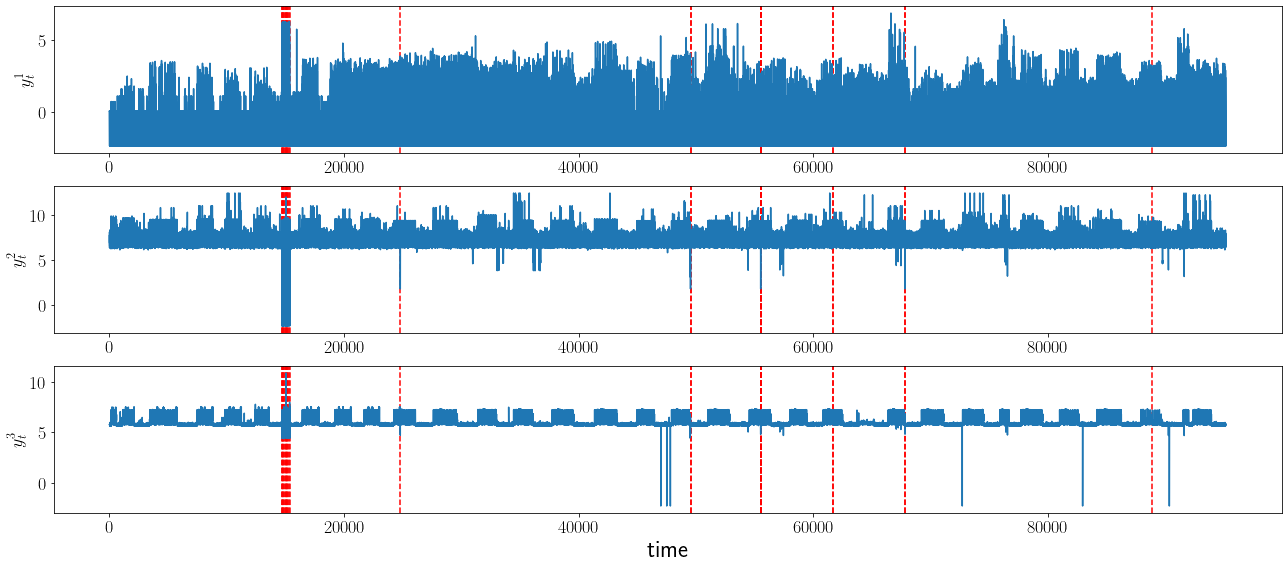

In [91]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(18, 8))

axes[0].plot(X[:, 0])
axes[0].set_ylabel(r'$y_{t}^{1}$', fontsize=18)
axes[0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[0].tick_params(labelsize=18)

axes[1].plot(X[:, 1])
axes[1].set_ylabel(r'$y_{t}^{2}$', fontsize=18)
axes[1].xaxis.set_tick_params(which='both', labelbottom=True)
axes[1].tick_params(labelsize=18)

axes[2].plot(X[:, 2])
axes[2].set_xlabel('time', fontsize=24)
axes[2].set_ylabel(r'$y_{t}^{3}$', fontsize=18)
axes[2].tick_params(labelsize=18)

for i in range(len(y)):
    if y[i] == 1:
        axes[0].axvline(i, linestyle='dashed', color='red', zorder=0)
        axes[1].axvline(i, linestyle='dashed', color='red', zorder=0)
        axes[2].axvline(i, linestyle='dashed', color='red', zorder=0)

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'plot_smtp.pdf'), bbox_inches='tight', dpi=200)

In [20]:
np.where(y==1)[0] + 1

array([14692, 14742, 14789, 14833, 14888, 14967, 15016, 15043, 15099,
       15165, 15221, 15283, 15366, 24788, 49528, 49529, 55502, 55503,
       55504, 55505, 55506, 55507, 55508, 55509, 55510, 61672, 61673,
       67813, 67814, 88859])

## SDEM

In [21]:
def calc_scores_sdem(X, r, k, alpha=1.0, seed=0):
    np.random.seed(seed)
    rho_const = np.repeat([r], X.shape[0])
    sdem = SDEM(rho_const, alpha, n_components=k)

    sdem.fit(X[:10, :])
    #sdem.weights_ = np.repeat([1/k], k)
    #sdem.means_ = np.hstack([ 
    #                    np.random.uniform(np.min(X[:2000, col]), np.max(X[:2000, col]), k).reshape(-1, 1)
    #                    for col in range(X.shape[1])
    #                ])
    #sdem.covariances_ = np.stack([np.diag((X[:2000, :].max(axis=0) - X[:2000, :].min(axis=0))/10) for _ in k_list])

    for t in tqdm.tqdm(range(X.shape[0])):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_list)
    sigma_est = np.array(sdem.covariances_list)
    
    anom_scores = [np.nan] * 1000

    n_cluster = pi_est.shape[1]
    #anom_scores = []
    for t in range(1000, pi_est.shape[0]):
        #print('t =', t)
        p = np.zeros(n_cluster)
        for i in range(n_cluster):
            #print(sigma_est[t-1, i, :, :])
            p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :], allow_singular=True).pdf(X[t, :])
            #except:
            #    print(nearPD(sigma_est[t-1, i, :, :]))
            #    p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], nearPD(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(-np.log(-1.0/np.finfo(np.float).min))
    anom_scores = np.array(anom_scores)
    
    return anom_scores

In [22]:
n_trial = 5
#r_list = [0.0001, 0.0005, 0.001, 0.01]
#r_list = [0.01, 0.03, 0.05, 0.1]
r_list = [0.1, 0.3, 0.5]
k_list = [1, 2, 3]

auc_tr_sdem = np.zeros((n_trial, len(r_list), len(k_list)))
auc_te_sdem = np.zeros((n_trial, len(r_list), len(k_list)))

for n in range(n_trial):
    for i, r in enumerate(r_list):
        for j, k in enumerate(k_list):
            seed = i*len(r_list) + j
            anom_scores = calc_scores_sdem(X, r, k, alpha=1.0, seed=seed)

            fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[10000:40000], anom_scores[10000:40000], pos_label=1)
            auc_tr_sdem[n, i, j] = auc(fpr_tr, tpr_tr)

            fpr_te, tpr_te, thresholds_te = roc_curve(y[40000:], anom_scores[40000:], pos_label=1)
            auc_te_sdem[n, i, j] = auc(fpr_te, tpr_te)

100%|██████████| 95156/95156 [00:20<00:00, 4613.52it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 95156/95156 [00:24<00:00, 3904.63it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and g

In [23]:
np.mean(auc_tr_sdem, axis=0)

array([[0.9934124 , 0.99398291, 0.99570276],
       [0.97652238, 0.98102448, 0.98235843],
       [0.94002201, 0.949293  , 0.9517108 ]])

In [24]:
np.std(auc_tr_sdem, axis=0)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.11022302e-16, 0.00000000e+00, 1.11022302e-16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [25]:
np.mean(auc_te_sdem ,axis=0)

array([[0.82464409, 0.76508206, 0.77264917],
       [0.74003276, 0.71812205, 0.71068133],
       [0.64465678, 0.63496498, 0.62881982]])

In [26]:
np.std(auc_te_sdem, axis=0)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [39]:
np.unravel_index(np.argmax(auc_tr_sdem), auc_tr_sdem.shape)

(0, 1)

In [42]:
auc_tr_sdem[0, 1]

0.9939829063086583

In [43]:
auc_te_sdem[0, 1]

0.7650820638375045

## IEM

In [27]:
def calc_scores_iem(X, k, alpha=1.0, seed=0):
    np.random.seed(seed)
    rhos = 1.0 / np.arange(1, X.shape[0]+1)
    sdem = SDEM(rhos, alpha, n_components=k)

    sdem.fit(X[:10, :])
    #sdem.weights_ = np.repeat([1/k], k)
    #sdem.means_ = np.hstack([ 
    #                    np.random.uniform(np.min(X[:2000, col]), np.max(X[:2000, col]), k).reshape(-1, 1)
    #                    for col in range(X.shape[1])
    #                ])
    #sdem.covariances_ = np.stack([np.diag((X[:2000, :].max(axis=0) - X[:2000, :].min(axis=0))/10) for _ in k_list])

    for t in tqdm.tqdm(range(X.shape[0])):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_list)
    sigma_est = np.array(sdem.covariances_list)
    
    anom_scores = [np.nan] * 1000

    n_cluster = pi_est.shape[1]
    #anom_scores = []
    for t in range(1000, pi_est.shape[0]):
        #print('t =', t)
        p = np.zeros(n_cluster)
        for i in range(n_cluster):
            #print(sigma_est[t-1, i, :, :])
            p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :]).pdf(X[t, :])
            #except:
            #    print(nearPD(sigma_est[t-1, i, :, :]))
            #    p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], nearPD(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(-np.log(-1.0/np.finfo(np.float).min))
    anom_scores = np.array(anom_scores)
    
    return anom_scores

In [28]:
n_trial = 5
k_list = [1, 2, 3]

auc_tr_iem = np.zeros((n_trial, len(k_list)))
auc_te_iem = np.zeros((n_trial, len(k_list)))

for n in range(n_trial):
    for i, k in enumerate(k_list):
        seed = i
        anom_scores = calc_scores_iem(X, k, alpha=1.0, seed=seed)

        fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[10000:40000], anom_scores[10000:40000], pos_label=1)
        auc_tr_iem[n, i] = auc(fpr_tr, tpr_tr)

        fpr_te, tpr_te, thresholds_te = roc_curve(y[40000:], anom_scores[40000:], pos_label=1)
        auc_te_iem[n, i] = auc(fpr_te, tpr_te)

100%|██████████| 95156/95156 [00:19<00:00, 4815.41it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 95156/95156 [00:23<00:00, 4106.21it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and g

In [30]:
np.mean(auc_tr_iem, axis=0)

array([0.99962363, 0.99943307, 0.99967604])

In [31]:
np.std(auc_tr_iem, axis=0)

array([1.11022302e-16, 0.00000000e+00, 0.00000000e+00])

In [32]:
np.mean(auc_te_iem, axis=0)

array([0.66208118, 0.74436435, 0.74444369])

In [33]:
np.std(auc_te_iem, axis=0)

array([0., 0., 0.])

In [26]:
auc_tr_iem[np.argmax(auc_tr_iem)]

0.999676039294528

In [27]:
auc_te_iem[np.argmax(auc_tr_iem)]

0.7444436887921654

## sEM

In [34]:
def calc_scores_sem(X, theta0, r, k, seed=0):
    np.random.seed(seed)
    
    rho_const = np.repeat([r], X.shape[0])
    pi_est, mu_est, sigma_est = sem(X, theta0, rho_const)
    
    anom_scores = [np.nan]
    for t in range(1, pi_est.shape[0]):
        p = np.zeros(k)
        for i in range(k):
            p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :], allow_singular=True).pdf(X[t, :])
            #except:
            #    print(nearPD(sigma_est[t-1, i, :, :]))
            #    p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], nearPD(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(-np.log(-1.0/np.finfo(np.float).min))
                        
    return anom_scores

In [35]:
n_trial = 5

k_list = [1, 2, 3]
r_list = [0.0001, 0.0003, 0.0005, 0.001]

auc_tr_sem = np.zeros((n_trial, len(r_list), len(k_list)))
auc_te_sem = np.zeros((n_trial, len(r_list), len(k_list)))

for n in range(n_trial):
    for i, r in enumerate(r_list):
        for j, k in enumerate(k_list):
            print('r =', r, ', k =', k)
            seed = i*len(k_list) + j
            np.random.seed(seed)

            pi0 = np.array([1/k] * k).reshape(-1, 1)
            mu0 = np.hstack([ 
                      np.random.uniform(np.min(X[:40000, col]), np.max(X[:40000, col]), k).reshape(-1, 1)
                      for col in range(X.shape[1])
                  ])
            sigma0 = np.stack([np.diag( (X[:40000, :].max(axis=0) - X[:40000, :].min(axis=0)) /10) for _ in range(k)])
            theta0 = Theta(pi0, mu0, sigma0)

            anom_scores = calc_scores_sem(X, theta0, r, k, seed=seed)

            fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[10000:40000], anom_scores[10000:40000], pos_label=1)
            auc_tr_sem[n, i, j] = auc(fpr_tr, tpr_tr)

            fpr_te, tpr_te, thresholds_te = roc_curve(y[40000:], anom_scores[40000:], pos_label=1)
            auc_te_sem[n, i, j] = auc(fpr_te, tpr_te)

  0%|          | 0/95156 [00:00<?, ?it/s]/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
  0%|          | 282/95156 [00:00<00:33, 2812.10it/s]

r = 0.0001 , k = 1


100%|██████████| 95156/95156 [00:26<00:00, 3524.61it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0%|          | 251/95156 [00:00<00:37, 2502.09it/s]

r = 0.0001 , k = 2


  0%|          | 170/95156 [00:00<00:55, 1698.32it/s]

r = 0.0001 , k = 3


  0%|          | 371/95156 [00:00<00:25, 3706.42it/s]

r = 0.0003 , k = 1


  0%|          | 223/95156 [00:00<00:42, 2228.73it/s]

r = 0.0003 , k = 2


  0%|          | 151/95156 [00:00<01:03, 1505.56it/s]

r = 0.0003 , k = 3


  0%|          | 384/95156 [00:00<00:24, 3831.76it/s]

r = 0.0005 , k = 1


  0%|          | 224/95156 [00:00<00:42, 2234.48it/s]

r = 0.0005 , k = 2


  0%|          | 166/95156 [00:00<00:57, 1651.89it/s]

r = 0.0005 , k = 3


  0%|          | 321/95156 [00:00<00:29, 3201.04it/s]

r = 0.001 , k = 1


  0%|          | 203/95156 [00:00<00:46, 2024.84it/s]

r = 0.001 , k = 2


  0%|          | 131/95156 [00:00<01:13, 1299.58it/s]

r = 0.001 , k = 3


  0%|          | 357/95156 [00:00<00:26, 3565.80it/s]

r = 0.0001 , k = 1


  0%|          | 223/95156 [00:00<00:42, 2225.50it/s]

r = 0.0001 , k = 2


  0%|          | 162/95156 [00:00<00:58, 1619.87it/s]

r = 0.0001 , k = 3


  0%|          | 371/95156 [00:00<00:25, 3702.08it/s]

r = 0.0003 , k = 1


  0%|          | 221/95156 [00:00<00:42, 2208.04it/s]

r = 0.0003 , k = 2


  0%|          | 162/95156 [00:00<00:58, 1610.58it/s]

r = 0.0003 , k = 3


  0%|          | 316/95156 [00:00<00:30, 3157.19it/s]

r = 0.0005 , k = 1


  0%|          | 183/95156 [00:00<00:52, 1825.29it/s]

r = 0.0005 , k = 2


  0%|          | 158/95156 [00:00<01:00, 1570.78it/s]

r = 0.0005 , k = 3


  0%|          | 400/95156 [00:00<00:23, 3989.95it/s]

r = 0.001 , k = 1


  0%|          | 443/95156 [00:00<00:42, 2216.19it/s]

r = 0.001 , k = 2


  0%|          | 135/95156 [00:00<01:10, 1344.06it/s]

r = 0.001 , k = 3


  0%|          | 367/95156 [00:00<00:25, 3666.15it/s]

r = 0.0001 , k = 1


  0%|          | 226/95156 [00:00<00:42, 2253.51it/s]

r = 0.0001 , k = 2


  0%|          | 162/95156 [00:00<00:59, 1610.02it/s]

r = 0.0001 , k = 3


  0%|          | 348/95156 [00:00<00:27, 3473.02it/s]

r = 0.0003 , k = 1


  0%|          | 216/95156 [00:00<00:44, 2155.39it/s]

r = 0.0003 , k = 2


  0%|          | 148/95156 [00:00<01:04, 1478.08it/s]

r = 0.0003 , k = 3


  1%|          | 753/95156 [00:00<00:25, 3761.91it/s]

r = 0.0005 , k = 1


  0%|          | 232/95156 [00:00<00:41, 2312.81it/s]

r = 0.0005 , k = 2


  0%|          | 159/95156 [00:00<01:00, 1582.17it/s]

r = 0.0005 , k = 3


  0%|          | 387/95156 [00:00<00:24, 3862.39it/s]

r = 0.001 , k = 1


  0%|          | 221/95156 [00:00<00:43, 2202.07it/s]

r = 0.001 , k = 2


  0%|          | 168/95156 [00:00<00:56, 1671.04it/s]

r = 0.001 , k = 3


  1%|          | 661/95156 [00:00<00:28, 3316.92it/s]

r = 0.0001 , k = 1


  0%|          | 219/95156 [00:00<00:43, 2179.52it/s]

r = 0.0001 , k = 2


  0%|          | 165/95156 [00:00<00:57, 1641.68it/s]

r = 0.0001 , k = 3


  0%|          | 356/95156 [00:00<00:26, 3559.07it/s]

r = 0.0003 , k = 1


  0%|          | 232/95156 [00:00<00:40, 2316.29it/s]

r = 0.0003 , k = 2


  0%|          | 150/95156 [00:00<01:03, 1492.28it/s]

r = 0.0003 , k = 3


  0%|          | 381/95156 [00:00<00:24, 3804.14it/s]

r = 0.0005 , k = 1


  0%|          | 231/95156 [00:00<00:41, 2304.95it/s]

r = 0.0005 , k = 2


  0%|          | 158/95156 [00:00<01:00, 1577.84it/s]

r = 0.0005 , k = 3


  1%|          | 742/95156 [00:00<00:25, 3712.31it/s]

r = 0.001 , k = 1


  0%|          | 219/95156 [00:00<00:43, 2184.56it/s]

r = 0.001 , k = 2


  0%|          | 158/95156 [00:00<01:00, 1574.30it/s]

r = 0.001 , k = 3


  0%|          | 376/95156 [00:00<00:25, 3758.76it/s]

r = 0.0001 , k = 1


  0%|          | 224/95156 [00:00<00:42, 2239.27it/s]

r = 0.0001 , k = 2


  0%|          | 166/95156 [00:00<00:57, 1651.05it/s]

r = 0.0001 , k = 3


  0%|          | 348/95156 [00:00<00:27, 3472.30it/s]

r = 0.0003 , k = 1


  0%|          | 221/95156 [00:00<00:42, 2208.99it/s]

r = 0.0003 , k = 2


  0%|          | 164/95156 [00:00<00:58, 1637.69it/s]

r = 0.0003 , k = 3


  0%|          | 387/95156 [00:00<00:24, 3866.01it/s]

r = 0.0005 , k = 1


  0%|          | 224/95156 [00:00<00:42, 2237.05it/s]

r = 0.0005 , k = 2


  0%|          | 151/95156 [00:00<01:02, 1508.46it/s]

r = 0.0005 , k = 3


  0%|          | 321/95156 [00:00<00:29, 3209.09it/s]

r = 0.001 , k = 1


  0%|          | 222/95156 [00:00<00:42, 2218.49it/s]

r = 0.001 , k = 2


  0%|          | 154/95156 [00:00<01:02, 1531.68it/s]

r = 0.001 , k = 3


100%|██████████| 95156/95156 [01:03<00:00, 1490.59it/s]


In [36]:
np.mean(auc_tr_sem, axis=0)

array([[0.99441406, 0.9955646 , 0.99987494],
       [0.99974036, 0.99974036, 0.99972725],
       [0.99978323, 0.99984517, 0.99978323],
       [0.99917581, 0.9993497 , 0.99895666]])

In [38]:
np.std(auc_tr_sem, axis=0)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.11022302e-16, 1.11022302e-16, 0.00000000e+00],
       [0.00000000e+00, 1.11022302e-16, 0.00000000e+00],
       [1.11022302e-16, 0.00000000e+00, 0.00000000e+00]])

In [39]:
np.mean(auc_te_sem, axis=0)

array([[0.6874626 , 0.85846765, 0.90712164],
       [0.67746418, 0.67746418, 0.72133093],
       [0.67939563, 0.84466925, 0.68824413],
       [0.69762253, 0.69656896, 0.74514588]])

In [40]:
np.std(auc_te_sem, axis=0)

array([[0.00000000e+00, 1.11022302e-16, 1.11022302e-16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [44]:
np.unravel_index(np.argmax(auc_tr_sem), auc_tr_sem.shape)

(0, 1)

In [46]:
auc_tr_sem[0, 1]

0.9957027565244733

In [47]:
auc_te_sem[0, 1]

0.772649165759884

## SRA

In [41]:
#def calc_scores_sra(X, theta0, k, gamma, d0, M, L_alpha, seed=0):
def calc_scores_sra(X, theta0, k, gamma, ratio, M, seed=0):
    np.random.seed(seed)
    
    #rho = (d0+1) * np.exp(-gamma**2/M**2) / (2.0*L_alpha*gamma)
    rho = ratio * np.exp(-gamma**2/M**2) / (2.0*gamma)
    rho_const = np.repeat(rho, X.shape[0])
    pi_est, mu_est, sigma_est = sra(X, theta0, rho_const, gamma)
    
    anom_scores = []
    for t in range(pi_est.shape[0]):
        p = np.zeros(k)
        for i in range(k):
            p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :], allow_singular=True).pdf(X[t, :])
            #except:
            #    print(nearPD(sigma_est[t-1, i, :, :]))
            #    p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], nearPD(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(-np.log(-1.0/np.finfo(np.float).min))
                        
    return anom_scores

In [42]:
n_trial = 5
k_list = [2, 3]
gamma_list = [5, 10, 15]
ratio_list = [0.1, 0.5, 1.0]
#d0_list = [0.1, 0.5, 1.0]
#d0_list = [1.0, 5.0, 10.0]
#M_list = [0.5, 1.0, 2.0]
M_list = [1.0, 5.0, 10.0]
#L_alpha_list = [0.5, 1.0, 2.0]
#L_alpha_list = [2.0, 10.0, 20.0]

In [44]:
n_trial = 5

auc_sra_tot = np.zeros((n_trial, len(k_list), len(gamma_list), len(ratio_list), len(M_list)))
auc_sra_tr = np.zeros((n_trial, len(k_list), len(gamma_list), len(ratio_list), len(M_list)))
auc_sra_te = np.zeros((n_trial, len(k_list), len(gamma_list), len(ratio_list), len(M_list)))

for n in range(n_trial):
    for i, k in enumerate(k_list):
        pi0 = np.array([1/k] * k).reshape(-1, 1)
        mu0 = np.hstack([ 
                  np.random.uniform(np.min(X[:40000, col]), np.max(X[:40000, col]), k).reshape(-1, 1)
                  for col in range(X.shape[1])
              ])
        sigma0 = np.stack([np.diag((X[:40000, :].max(axis=0) - X[:40000, :].min(axis=0))/10) for _ in range(k)])
        theta0 = Theta(pi0, mu0, sigma0)
        for j, gamma in enumerate(gamma_list):
            for l, ratio in enumerate(ratio_list):
                for m, M in enumerate(M_list):
                    scores = calc_scores_sra(X, theta0, k, gamma, ratio, M)
                    fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
                    #auc_sra_tot[n, i, j, l, m, p] = auc(fpr, tpr)
                    auc_sra_tot[n, i, j, l, m] = auc(fpr, tpr)

                    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[10000:40000], scores[10000:40000], pos_label=1)
                    #auc_sra_tr[n, i, j, l, m, p] = auc(fpr_tr, tpr_tr)
                    auc_sra_tr[n, i, j, l, m] = auc(fpr_tr, tpr_tr)

                    fpr_te, tpr_te, thresholds_te = roc_curve(y[40000:], scores[40000 :], pos_label=1)
                    #auc_sra_te[n, i, j, l, m, p] = auc(fpr_te, tpr_te)
                    auc_sra_te[n, i, j, l, m] = auc(fpr_te, tpr_te)
                    #print('gamma=', gamma, ', ratio=', ratio, ', M=', M, ':', auc_sra_te[n, i, j, l, m, p])
                    print('gamma=', gamma, ', ratio=', ratio, ', M=', M, ':', auc_sra_te[n, i, j, l, m])

"""
auc_sra_tot = np.zeros((n_trial, len(k_list), len(gamma_list), len(ratio_list), len(M_list)))
auc_sra_tr = np.zeros((n_trial, len(k_list), len(gamma_list), len(ratio_list), len(M_list)))
auc_sra_te = np.zeros((n_trial, len(k_list), len(gamma_list), len(ratio_list), len(M_list)))

for n in range(n_trial):
    for i, k in enumerate(k_list):
        pi0 = np.array([1/k] * k).reshape(-1, 1)
        mu0 = np.hstack([ 
                  np.random.uniform(np.min(X[:40000, col]), np.max(X[:40000, col]), k).reshape(-1, 1)
                  for col in range(X.shape[1])
              ])
        sigma0 = np.stack([np.diag((X[:40000, :].max(axis=0) - X[:40000, :].min(axis=0))/10) for _ in range(k)])
        theta0 = Theta(pi0, mu0, sigma0)
        for j, gamma in enumerate(gamma_list):
            for l, ratio in enumerate(ratio_list):
                for m, M in enumerate(M_list):
                    scores = calc_scores_sra(X, theta0, k, gamma, ratio, M)
                    fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
                    #auc_sra_tot[n, i, j, l, m, p] = auc(fpr, tpr)
                    auc_sra_tot[n, i, j, l, m] = auc(fpr, tpr)
                    
                    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[10000:40000], scores[10000:40000], pos_label=1)
                    #auc_sra_tr[n, i, j, l, m, p] = auc(fpr_tr, tpr_tr)
                    auc_sra_tr[n, i, j, l, m] = auc(fpr_tr, tpr_tr)
                    
                    fpr_te, tpr_te, thresholds_te = roc_curve(y[40000:], scores[40000 :], pos_label=1)
                    #auc_sra_te[n, i, j, l, m, p] = auc(fpr_te, tpr_te)
                    auc_sra_te[n, i, j, l, m] = auc(fpr_te, tpr_te)
                    #print('gamma=', gamma, ', ratio=', ratio, ', M=', M, ':', auc_sra_te[n, i, j, l, m, p])
                    print('gamma=', gamma, ', ratio=', ratio, ', M=', M, ':', auc_sra_te[n, i, j, l, m])
"""
   
"""
for l, d0 in enumerate(d0_list):
    for m, M in enumerate(M_list):
        for p, L_alpha in enumerate(L_alpha_list):
            scores = calc_scores_sra(X, theta0, k, gamma, d0, M, L_alpha)
            fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
            auc_sra_tot[n, i, j, l, m, p] = auc(fpr, tpr)

            fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], scores[1000:2000], pos_label=1)
            auc_sra_tr[n, i, j, l, m, p] = auc(fpr_tr, tpr_tr)

            fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], scores[2000:], pos_label=1)
            auc_sra_te[n, i, j, l, m, p] = auc(fpr_te, tpr_te)
            print('gamma=', gamma, ', d0=', d0, ', M=', M, ', L_alpha=', L_alpha, ':', auc_sra_te[n, i, j, l, m, p])
"""

  0%|          | 0/95156 [00:00<?, ?it/s]/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
100%|██████████| 95156/95156 [00:42<00:00, 2217.24it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  1%|          | 505/95156 [00:00<00:37, 2525.51it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.8960282916213276


  0%|          | 238/95156 [00:00<00:39, 2378.58it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9236035545883207


  0%|          | 236/95156 [00:00<00:40, 2357.34it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9167380758070366


  0%|          | 221/95156 [00:00<00:43, 2203.70it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.8960282916213276


  0%|          | 220/95156 [00:00<00:43, 2199.25it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9192753672470075


  0%|          | 199/95156 [00:00<00:47, 1989.05it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.8768317011244107


  0%|          | 229/95156 [00:00<00:41, 2287.78it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.8960282916213276


  0%|          | 191/95156 [00:00<00:49, 1909.14it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.8832585237577076


  0%|          | 197/95156 [00:00<00:48, 1967.03it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.5


  0%|          | 337/95156 [00:00<00:56, 1690.03it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.8960282916213276


  0%|          | 220/95156 [00:00<00:43, 2191.63it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.8960736307580703


  0%|          | 251/95156 [00:00<00:37, 2508.06it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.8992020311933261


  0%|          | 238/95156 [00:00<00:39, 2374.83it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.8960282916213276


  0%|          | 243/95156 [00:00<00:39, 2428.54it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.896146173376859


  1%|          | 481/95156 [00:00<00:39, 2415.41it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9191472841857091


  0%|          | 197/95156 [00:00<00:48, 1962.58it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.8960282916213276


  0%|          | 210/95156 [00:00<00:45, 2096.42it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9192753672470075


  0%|          | 201/95156 [00:00<00:47, 2005.78it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.8960282916213276


  1%|          | 492/95156 [00:00<00:38, 2479.86it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.8960282916213276


  0%|          | 200/95156 [00:00<00:47, 1999.02it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.8961280377221618


  0%|          | 192/95156 [00:00<00:49, 1919.00it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.8960282916213276


  0%|          | 429/95156 [00:00<00:44, 2150.87it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.8960282916213276


  0%|          | 209/95156 [00:00<00:45, 2081.75it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.898657961552412


  0%|          | 209/95156 [00:00<00:45, 2084.98it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.8960282916213276


  0%|          | 205/95156 [00:00<00:46, 2047.26it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.8960282916213275


  0%|          | 175/95156 [00:00<00:54, 1741.81it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9215723612622415


  0%|          | 166/95156 [00:00<00:57, 1657.66it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 166/95156 [00:00<00:57, 1652.13it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9027957245194052


  0%|          | 169/95156 [00:00<00:56, 1687.33it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9083185981138919


  0%|          | 164/95156 [00:00<00:58, 1633.73it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 178/95156 [00:00<00:53, 1777.00it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9007208922742111


  0%|          | 129/95156 [00:00<01:13, 1285.15it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.8825954388828438


  0%|          | 140/95156 [00:00<01:08, 1396.24it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 154/95156 [00:00<01:01, 1532.96it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.8832619241929633


  0%|          | 155/95156 [00:00<01:01, 1544.73it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.5


  0%|          | 137/95156 [00:00<01:09, 1369.91it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 172/95156 [00:00<00:55, 1715.29it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.8850199492201668


  0%|          | 170/95156 [00:00<00:56, 1693.41it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9094124047878128


  0%|          | 137/95156 [00:00<01:09, 1369.40it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 146/95156 [00:00<01:05, 1453.41it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.8887740297424737


  0%|          | 154/95156 [00:00<01:01, 1536.45it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9082794931084512


  0%|          | 165/95156 [00:00<00:57, 1643.20it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 165/95156 [00:00<00:57, 1648.87it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.8966449038810301


  0%|          | 169/95156 [00:00<00:56, 1682.30it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9007208922742111


  0%|          | 160/95156 [00:00<00:59, 1591.41it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 166/95156 [00:00<00:57, 1648.39it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.8844124047878129


  0%|          | 135/95156 [00:00<01:10, 1342.54it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.8875589408777657


  0%|          | 158/95156 [00:00<01:00, 1575.13it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 156/95156 [00:00<01:01, 1556.05it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.8844214726151615


  0%|          | 154/95156 [00:00<01:02, 1532.07it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9085963003264418


  0%|          | 164/95156 [00:00<00:58, 1637.35it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 163/95156 [00:00<00:58, 1627.36it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.8844305404425099


  0%|          | 245/95156 [00:00<00:38, 2440.87it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.902177978781284


  0%|          | 241/95156 [00:00<00:39, 2403.00it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.8960373594486761


  0%|          | 232/95156 [00:00<00:40, 2319.14it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9238121146173377


  0%|          | 245/95156 [00:00<00:38, 2449.56it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9168145856002902


  0%|          | 202/95156 [00:00<00:47, 2016.21it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.8960373594486761


  0%|          | 248/95156 [00:00<00:38, 2471.28it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.91881347479144


  0%|          | 202/95156 [00:00<00:47, 2014.20it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.8736409593761334


  0%|          | 214/95156 [00:00<00:44, 2139.10it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.8960373594486761


  0%|          | 194/95156 [00:00<00:48, 1939.11it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.8807399347116431


  0%|          | 417/95156 [00:00<00:45, 2083.43it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.5


  0%|          | 440/95156 [00:00<00:43, 2202.14it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.8960373594486761


  0%|          | 466/95156 [00:00<00:40, 2333.92it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.8960917664127676


  0%|          | 235/95156 [00:00<00:40, 2349.16it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.8992020311933261


  0%|          | 204/95156 [00:00<00:46, 2032.62it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.8960373594486761


  0%|          | 223/95156 [00:00<00:42, 2221.43it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.896146173376859


  0%|          | 210/95156 [00:00<00:45, 2093.61it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9190804089590133


  0%|          | 257/95156 [00:00<00:37, 2560.19it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.8960373594486761


  0%|          | 231/95156 [00:00<00:41, 2309.26it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.8962368516503446


  0%|          | 236/95156 [00:00<00:40, 2355.55it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.91881347479144


  0%|          | 234/95156 [00:00<00:40, 2332.61it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.8960373594486761


  0%|          | 210/95156 [00:00<00:45, 2093.47it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.896037359448676


  0%|          | 239/95156 [00:00<00:39, 2380.88it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.8961371055495104


  0%|          | 198/95156 [00:00<00:48, 1976.77it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.8960373594486761


  0%|          | 212/95156 [00:00<00:44, 2118.90it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.8960373594486761


  0%|          | 461/95156 [00:00<00:40, 2317.87it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.8987123685165034


  0%|          | 444/95156 [00:00<00:42, 2216.69it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.8960373594486761


  0%|          | 242/95156 [00:00<00:39, 2411.11it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.8960464272760247


  0%|          | 149/95156 [00:00<01:03, 1488.16it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9217899891186072


  0%|          | 168/95156 [00:00<00:56, 1674.33it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 154/95156 [00:00<01:01, 1539.77it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9027957245194052


  0%|          | 173/95156 [00:00<00:54, 1729.32it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9083185981138919


  0%|          | 168/95156 [00:00<00:56, 1677.33it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 155/95156 [00:00<01:01, 1542.05it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9007208922742111


  0%|          | 165/95156 [00:00<00:57, 1646.23it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.8825954388828438


  0%|          | 166/95156 [00:00<00:57, 1654.72it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 157/95156 [00:00<01:00, 1569.75it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.8832619241929633


  0%|          | 150/95156 [00:00<01:03, 1497.84it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.5


  0%|          | 161/95156 [00:00<00:59, 1605.31it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 103/95156 [00:00<01:32, 1028.31it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.8850199492201668


  0%|          | 184/95156 [00:00<00:51, 1837.85it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9094124047878128


  0%|          | 130/95156 [00:00<01:13, 1292.74it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 171/95156 [00:00<00:55, 1706.08it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.8887740297424737


  0%|          | 182/95156 [00:00<00:52, 1816.32it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9082794931084512


  0%|          | 148/95156 [00:00<01:04, 1477.87it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 164/95156 [00:00<00:58, 1635.58it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.8966449038810301


  0%|          | 163/95156 [00:00<00:58, 1621.68it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9007208922742111


  0%|          | 168/95156 [00:00<00:56, 1674.36it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 179/95156 [00:00<00:53, 1785.88it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.8844124047878129


  0%|          | 171/95156 [00:00<00:55, 1707.83it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.8875589408777657


  0%|          | 170/95156 [00:00<00:56, 1687.43it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 166/95156 [00:00<00:57, 1652.86it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.8844214726151615


  0%|          | 149/95156 [00:00<01:03, 1489.58it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9085963003264418


  0%|          | 165/95156 [00:00<00:57, 1649.51it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 130/95156 [00:00<01:13, 1296.59it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.8844305404425099


  0%|          | 227/95156 [00:00<00:41, 2261.30it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.902177978781284


  0%|          | 240/95156 [00:00<00:39, 2390.77it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.8960373594486761


  0%|          | 240/95156 [00:00<00:39, 2394.83it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9238121146173377


  0%|          | 237/95156 [00:00<00:40, 2363.71it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9168145856002902


  0%|          | 238/95156 [00:00<00:39, 2373.36it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.8960373594486761


  0%|          | 233/95156 [00:00<00:40, 2326.65it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.91881347479144


  0%|          | 218/95156 [00:00<00:43, 2175.30it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.8736409593761334


  0%|          | 194/95156 [00:00<00:49, 1933.19it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.8960373594486761


  0%|          | 199/95156 [00:00<00:47, 1980.92it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.8807399347116431


  1%|          | 523/95156 [00:00<00:36, 2619.51it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.5


  0%|          | 243/95156 [00:00<00:39, 2429.42it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.8960373594486761


  0%|          | 212/95156 [00:00<00:44, 2110.11it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.8960917664127676


  0%|          | 220/95156 [00:00<00:43, 2198.06it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.8992020311933261


  0%|          | 211/95156 [00:00<00:45, 2107.71it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.8960373594486761


  0%|          | 245/95156 [00:00<00:38, 2443.69it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.896146173376859


  0%|          | 223/95156 [00:00<00:42, 2222.38it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9190804089590133


  0%|          | 201/95156 [00:00<00:47, 2003.77it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.8960373594486761


  0%|          | 199/95156 [00:00<00:47, 1986.34it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.8962368516503446


  0%|          | 472/95156 [00:00<00:40, 2359.29it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.91881347479144


  0%|          | 229/95156 [00:00<00:41, 2282.74it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.8960373594486761


  0%|          | 268/95156 [00:00<00:35, 2676.25it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.896037359448676


  0%|          | 223/95156 [00:00<00:42, 2221.44it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.8961371055495104


  1%|          | 502/95156 [00:00<00:37, 2521.51it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.8960373594486761


  0%|          | 226/95156 [00:00<00:42, 2253.53it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.8960373594486761


  0%|          | 240/95156 [00:00<00:39, 2394.35it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.8987123685165034


  0%|          | 234/95156 [00:00<00:40, 2334.44it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.8960373594486761


  0%|          | 248/95156 [00:00<00:38, 2479.33it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.8960464272760247


  0%|          | 171/95156 [00:00<00:55, 1705.96it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9217899891186072


  0%|          | 138/95156 [00:00<01:09, 1375.45it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 123/95156 [00:00<01:17, 1229.46it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9027957245194052


  0%|          | 135/95156 [00:00<01:10, 1343.41it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9083185981138919


  0%|          | 166/95156 [00:00<00:57, 1655.55it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 152/95156 [00:00<01:02, 1519.32it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9007208922742111


  0%|          | 153/95156 [00:00<01:02, 1523.15it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.8825954388828438


  0%|          | 145/95156 [00:00<01:05, 1447.35it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 170/95156 [00:00<00:55, 1697.01it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.8832619241929633


  0%|          | 168/95156 [00:00<00:56, 1676.82it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.5


  0%|          | 162/95156 [00:00<00:58, 1614.17it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 169/95156 [00:00<00:56, 1685.92it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.8850199492201668


  0%|          | 149/95156 [00:00<01:03, 1488.62it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9094124047878128


  0%|          | 142/95156 [00:00<01:07, 1414.08it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 132/95156 [00:00<01:12, 1317.77it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.8887740297424737


  0%|          | 151/95156 [00:00<01:03, 1502.50it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9082794931084512


  0%|          | 116/95156 [00:00<01:22, 1153.43it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 145/95156 [00:00<01:05, 1441.67it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.8966449038810301


  0%|          | 155/95156 [00:00<01:01, 1548.19it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9007208922742111


  0%|          | 153/95156 [00:00<01:02, 1525.18it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 334/95156 [00:00<00:55, 1693.27it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.8844124047878129


  0%|          | 336/95156 [00:00<00:56, 1685.34it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.8875589408777657


  0%|          | 337/95156 [00:00<00:56, 1685.92it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 161/95156 [00:00<00:59, 1603.54it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.8844214726151615


  0%|          | 332/95156 [00:00<00:56, 1675.14it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9085963003264418


  0%|          | 156/95156 [00:00<01:00, 1558.85it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 332/95156 [00:00<00:56, 1674.39it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.8844305404425099


  1%|          | 487/95156 [00:00<00:38, 2455.62it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.902177978781284


  0%|          | 229/95156 [00:00<00:41, 2289.43it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.8960373594486761


  0%|          | 230/95156 [00:00<00:41, 2295.45it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9238121146173377


  0%|          | 473/95156 [00:00<00:39, 2380.41it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9168145856002902


  0%|          | 459/95156 [00:00<00:41, 2295.79it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.8960373594486761


  0%|          | 452/95156 [00:00<00:41, 2275.85it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.91881347479144


  0%|          | 475/95156 [00:00<00:39, 2375.19it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.8736409593761334


  0%|          | 217/95156 [00:00<00:43, 2163.06it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.8960373594486761


  0%|          | 441/95156 [00:00<00:42, 2203.15it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.8807399347116431


  0%|          | 227/95156 [00:00<00:41, 2266.40it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.5


  0%|          | 468/95156 [00:00<00:40, 2361.42it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.8960373594486761


  0%|          | 234/95156 [00:00<00:40, 2336.65it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.8960917664127676


  0%|          | 217/95156 [00:00<00:43, 2165.35it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.8992020311933261


  1%|          | 486/95156 [00:00<00:38, 2453.49it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.8960373594486761


  1%|          | 478/95156 [00:00<00:39, 2407.61it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.896146173376859


  0%|          | 461/95156 [00:00<00:40, 2315.93it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9190804089590133


  0%|          | 473/95156 [00:00<00:39, 2379.70it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.8960373594486761


  1%|          | 483/95156 [00:00<00:39, 2420.88it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.8962368516503446


  1%|          | 490/95156 [00:00<00:38, 2452.96it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.91881347479144


  0%|          | 473/95156 [00:00<00:39, 2371.83it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.8960373594486761


  0%|          | 216/95156 [00:00<00:44, 2155.69it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.896037359448676


  0%|          | 233/95156 [00:00<00:40, 2323.43it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.8961371055495104


  0%|          | 216/95156 [00:00<00:44, 2152.62it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.8960373594486761


  1%|          | 476/95156 [00:00<00:39, 2391.43it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.8960373594486761


  0%|          | 459/95156 [00:00<00:40, 2312.84it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.8987123685165034


  0%|          | 222/95156 [00:00<00:42, 2219.38it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.8960373594486761


  0%|          | 473/95156 [00:00<00:39, 2374.25it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.8960464272760247


  0%|          | 165/95156 [00:00<00:57, 1643.92it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9217899891186072


  0%|          | 158/95156 [00:00<01:00, 1577.16it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 338/95156 [00:00<00:55, 1700.87it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9027957245194052


  0%|          | 346/95156 [00:00<00:54, 1732.14it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9083185981138919


  0%|          | 165/95156 [00:00<00:57, 1643.93it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 159/95156 [00:00<00:59, 1588.06it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9007208922742111


  0%|          | 162/95156 [00:00<00:58, 1611.47it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.8825954388828438


  0%|          | 329/95156 [00:00<00:57, 1657.56it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 149/95156 [00:00<01:03, 1489.07it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.8832619241929633


  0%|          | 156/95156 [00:00<01:00, 1558.02it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.5


  0%|          | 158/95156 [00:00<01:00, 1574.10it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 351/95156 [00:00<00:53, 1756.12it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.8850199492201668


  0%|          | 322/95156 [00:00<00:59, 1600.58it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9094124047878128


  0%|          | 333/95156 [00:00<00:56, 1672.68it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 339/95156 [00:00<00:55, 1708.84it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.8887740297424737


  0%|          | 336/95156 [00:00<00:55, 1694.01it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9082794931084512


  0%|          | 327/95156 [00:00<00:57, 1643.97it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 339/95156 [00:00<00:55, 1694.01it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.8966449038810301


  0%|          | 147/95156 [00:00<01:04, 1461.95it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9007208922742111


  0%|          | 166/95156 [00:00<00:57, 1652.56it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 155/95156 [00:00<01:01, 1542.77it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.8844124047878129


  0%|          | 162/95156 [00:00<00:58, 1611.94it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.8875589408777657


  0%|          | 157/95156 [00:00<01:00, 1563.80it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 155/95156 [00:00<01:01, 1545.92it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.8844214726151615


  0%|          | 162/95156 [00:00<00:58, 1619.66it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9085963003264418


  0%|          | 147/95156 [00:00<01:04, 1468.02it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 353/95156 [00:00<00:53, 1769.63it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.8844305404425099


  0%|          | 206/95156 [00:00<00:46, 2057.51it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.902177978781284


  0%|          | 229/95156 [00:00<00:41, 2285.88it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.8960373594486761


  0%|          | 439/95156 [00:00<00:42, 2206.54it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9238121146173377


  1%|          | 478/95156 [00:00<00:39, 2397.36it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9168145856002902


  0%|          | 241/95156 [00:00<00:39, 2407.60it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.8960373594486761


  0%|          | 234/95156 [00:00<00:40, 2337.00it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.91881347479144


  0%|          | 193/95156 [00:00<00:49, 1924.81it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.8736409593761334


  0%|          | 228/95156 [00:00<00:41, 2274.73it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.8960373594486761


  0%|          | 225/95156 [00:00<00:42, 2247.60it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.8807399347116431


  0%|          | 233/95156 [00:00<00:40, 2325.98it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.5


  0%|          | 451/95156 [00:00<00:42, 2250.80it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.8960373594486761


  0%|          | 472/95156 [00:00<00:40, 2360.74it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.8960917664127676


  1%|          | 477/95156 [00:00<00:39, 2388.90it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.8992020311933261


  1%|          | 484/95156 [00:00<00:38, 2428.39it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.8960373594486761


  0%|          | 459/95156 [00:00<00:41, 2300.00it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.896146173376859


  1%|          | 481/95156 [00:00<00:39, 2413.15it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9190804089590133


  0%|          | 470/95156 [00:00<00:39, 2375.27it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.8960373594486761


  1%|          | 478/95156 [00:00<00:39, 2396.39it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.8962368516503446


  0%|          | 469/95156 [00:00<00:39, 2370.46it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.91881347479144


  0%|          | 237/95156 [00:00<00:40, 2365.11it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.8960373594486761


  1%|          | 481/95156 [00:00<00:39, 2411.41it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.896037359448676


  0%|          | 471/95156 [00:00<00:40, 2362.44it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.8961371055495104


  0%|          | 465/95156 [00:00<00:40, 2322.21it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.8960373594486761


  1%|          | 481/95156 [00:00<00:39, 2416.82it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.8960373594486761


  1%|          | 490/95156 [00:00<00:38, 2457.53it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.8987123685165034


  0%|          | 454/95156 [00:00<00:41, 2276.55it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.8960373594486761


  0%|          | 198/95156 [00:00<00:48, 1973.88it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.8960464272760247


  0%|          | 164/95156 [00:00<00:58, 1631.89it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9217899891186072


  0%|          | 342/95156 [00:00<00:55, 1711.28it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 343/95156 [00:00<00:55, 1713.69it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9027957245194052


  0%|          | 334/95156 [00:00<00:56, 1679.75it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9083185981138919


  0%|          | 148/95156 [00:00<01:04, 1476.32it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 158/95156 [00:00<01:00, 1574.43it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9007208922742111


  0%|          | 159/95156 [00:00<00:59, 1583.87it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.8825954388828438


  0%|          | 344/95156 [00:00<00:54, 1728.18it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 329/95156 [00:00<00:57, 1647.76it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.8832619241929633


  0%|          | 158/95156 [00:00<01:00, 1574.29it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.5


  0%|          | 344/95156 [00:00<00:54, 1728.15it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 335/95156 [00:00<00:56, 1687.52it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.8850199492201668


  0%|          | 323/95156 [00:00<00:58, 1627.95it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9094124047878128


  0%|          | 336/95156 [00:00<00:56, 1685.41it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 161/95156 [00:00<00:59, 1601.15it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.8887740297424737


  0%|          | 163/95156 [00:00<00:58, 1627.87it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9082794931084512


  0%|          | 342/95156 [00:00<00:54, 1725.51it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 158/95156 [00:00<01:00, 1576.72it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.8966449038810301


  0%|          | 157/95156 [00:00<01:00, 1568.92it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9007208922742111


  0%|          | 147/95156 [00:00<01:04, 1467.84it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.8844124047878128


  0%|          | 342/95156 [00:00<00:55, 1719.45it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.8844124047878129


  0%|          | 160/95156 [00:00<00:59, 1594.39it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.8875589408777657


  0%|          | 330/95156 [00:00<00:57, 1660.13it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.8844124047878128


  0%|          | 339/95156 [00:00<00:55, 1702.33it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.8844214726151615


  0%|          | 162/95156 [00:00<00:58, 1615.61it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9085963003264418


  0%|          | 328/95156 [00:00<00:57, 1655.29it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.8844124047878128


  0%|          | 158/95156 [00:00<01:00, 1577.00it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.8844305404425099


100%|██████████| 95156/95156 [00:54<00:00, 1746.82it/s]


gamma= 15 , ratio= 1.0 , M= 10.0 : 0.902177978781284


"\nfor l, d0 in enumerate(d0_list):\n    for m, M in enumerate(M_list):\n        for p, L_alpha in enumerate(L_alpha_list):\n            scores = calc_scores_sra(X, theta0, k, gamma, d0, M, L_alpha)\n            fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)\n            auc_sra_tot[n, i, j, l, m, p] = auc(fpr, tpr)\n\n            fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], scores[1000:2000], pos_label=1)\n            auc_sra_tr[n, i, j, l, m, p] = auc(fpr_tr, tpr_tr)\n\n            fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], scores[2000:], pos_label=1)\n            auc_sra_te[n, i, j, l, m, p] = auc(fpr_te, tpr_te)\n            print('gamma=', gamma, ', d0=', d0, ', M=', M, ', L_alpha=', L_alpha, ':', auc_sra_te[n, i, j, l, m, p])\n"

In [45]:
np.mean(auc_sra_tr, axis=0)

array([[[[0.87098646, 0.89941639, 0.93686053],
         [0.87098646, 0.96371974, 0.98173481],
         [0.87098646, 0.9813513 , 0.52861002]],

        [[0.87098646, 0.87118322, 0.87601881],
         [0.87098646, 0.87174015, 0.94609818],
         [0.87098646, 0.87242046, 0.96371974]],

        [[0.87098646, 0.87098646, 0.87166344],
         [0.87098646, 0.8709898 , 0.87547189],
         [0.87098646, 0.87099647, 0.89691856]]],


       [[[0.85459881, 0.89986994, 0.91742813],
         [0.85459881, 0.94547455, 0.97325419],
         [0.85459881, 0.97061962, 0.5338658 ]],

        [[0.85459881, 0.85563263, 0.88017742],
         [0.85459881, 0.85951777, 0.92041286],
         [0.85459881, 0.86730474, 0.94547455]],

        [[0.85459881, 0.85461549, 0.8581338 ],
         [0.85459881, 0.85464884, 0.87911025],
         [0.85459881, 0.85464884, 0.89863603]]]])

In [46]:
np.std(auc_sra_tr, axis=0)

array([[[[6.66977923e-06, 7.33675715e-05, 1.20056026e-04],
         [6.66977923e-06, 9.33769092e-05, 1.33395585e-05],
         [6.66977923e-06, 4.66884546e-05, 3.37490829e-03]],

        [[6.66977923e-06, 1.33395585e-05, 1.33395585e-05],
         [6.66977923e-06, 4.96506831e-17, 5.33582338e-05],
         [6.66977923e-06, 6.66977923e-06, 9.33769092e-05]],

        [[6.66977923e-06, 6.66977923e-06, 2.00093377e-05],
         [6.66977923e-06, 0.00000000e+00, 6.66977923e-06],
         [6.66977923e-06, 1.33395585e-05, 1.00046688e-04]]],


       [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.11022302e-16],
         [0.00000000e+00, 1.11022302e-16, 0.00000000e+00]],

        [[0.00000000e+00, 1.11022302e-16, 0.00000000e+00],
         [0.00000000e+00, 1.11022302e-16, 0.00000000e+00],
         [0.00000000e+00, 1.11022302e-16, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 1.11022302e-16],
         [0.00000000e+00, 1.11022302e-16, 0.

In [47]:
np.mean(auc_sra_te, axis=0)

array([[[[0.89603555, 0.9237704 , 0.91679928],
         [0.89603555, 0.91890585, 0.87427911],
         [0.89603555, 0.88124365, 0.5       ]],

        [[0.89603555, 0.89608814, 0.89920203],
         [0.89603555, 0.89614617, 0.91909378],
         [0.89603555, 0.89623685, 0.91890585]],

        [[0.89603555, 0.89603555, 0.89613529],
         [0.89603555, 0.89603555, 0.89870149],
         [0.89603555, 0.8960428 , 0.92174646]]],


       [[[0.8844124 , 0.90279572, 0.9083186 ],
         [0.8844124 , 0.90072089, 0.88259544],
         [0.8844124 , 0.88326192, 0.5       ]],

        [[0.8844124 , 0.88501995, 0.9094124 ],
         [0.8844124 , 0.88877403, 0.90827949],
         [0.8844124 , 0.8966449 , 0.90072089]],

        [[0.8844124 , 0.8844124 , 0.88755894],
         [0.8844124 , 0.88442147, 0.9085963 ],
         [0.8844124 , 0.88443054, 0.90217798]]]])

In [48]:
np.std(auc_sra_te, axis=0)

array([[[[3.62713094e-06, 8.34240116e-05, 3.06039173e-05],
         [3.62713094e-06, 1.84756982e-04, 1.27629670e-03],
         [3.62713094e-06, 1.00743562e-03, 0.00000000e+00]],

        [[3.62713094e-06, 7.25426188e-06, 1.11022302e-16],
         [3.62713094e-06, 1.11022302e-16, 2.67500907e-05],
         [3.62713094e-06, 4.96506831e-17, 1.84756982e-04]],

        [[3.62713094e-06, 3.62713094e-06, 3.62713094e-06],
         [3.62713094e-06, 3.62713094e-06, 2.17627856e-05],
         [3.62713094e-06, 7.25426188e-06, 8.70511425e-05]]],


       [[[1.11022302e-16, 1.11022302e-16, 0.00000000e+00],
         [1.11022302e-16, 1.11022302e-16, 0.00000000e+00],
         [1.11022302e-16, 0.00000000e+00, 0.00000000e+00]],

        [[1.11022302e-16, 0.00000000e+00, 1.11022302e-16],
         [1.11022302e-16, 0.00000000e+00, 0.00000000e+00],
         [1.11022302e-16, 0.00000000e+00, 1.11022302e-16]],

        [[1.11022302e-16, 0.00000000e+00, 0.00000000e+00],
         [1.11022302e-16, 0.00000000e+00, 0.

# ADWIN

In [49]:
from math import log, sqrt, fabs

import os, sys
#sys.path.append('./')

"""
Within one bucket row, each bucket contains same number of original data.
New buckets are added at the end of bucket row.
When old buckets need to be removed, they are taken from the head of this bucket row.
"""


class AdwinBucketRow:
    def __init__(self, max_buckets=5, next_bucket_row=None, previous_bucket_row=None):
        """
        :param max_buckets: Max bucket with one row
        :param next_bucket_row: Following bucket row
        :param previous_bucket_row: Previous bucket row
        """
        self.max_buckets = max_buckets

        # Current count of buckets in this bucket row
        self.bucket_count = 0

        self.next_bucket_row = next_bucket_row
        # Set previous bucket row connect to this bucket row
        if next_bucket_row is not None:
            next_bucket_row.previous_bucket_row = self

        self.previous_bucket_row = previous_bucket_row
        # Set next bucket connect to this bucket
        if previous_bucket_row is not None:
            previous_bucket_row.next_bucket_row = self

        # Init statistic number for each bucket
        self.bucket_sum = np.zeros(self.max_buckets + 1)
        self.bucket_variance = np.zeros(self.max_buckets + 1)

    def insert_bucket(self, value, variance):
        """
        Insert a new bucket at the end.
        """
        self.bucket_sum[self.bucket_count] = value
        self.bucket_variance[self.bucket_count] = variance
        self.bucket_count += 1

    def compress_bucket(self, number_deleted):
        """
        Remove the oldest buckets.
        """
        delete_index = self.max_buckets - number_deleted + 1
        self.bucket_sum[:delete_index] = self.bucket_sum[number_deleted:]
        self.bucket_sum[delete_index:] = np.zeros(number_deleted)

        self.bucket_variance[:delete_index] = self.bucket_variance[number_deleted:]
        self.bucket_variance[delete_index:] = np.zeros(number_deleted)

        self.bucket_count -= number_deleted

"""
List of bucket rows.
Add new bucket row at head of window, remove old bucket row from tail of window.
"""

class AdwinRowBucketList:
    def __init__(self, max_buckets=5):
        """
        :param max_buckets: Max number of bucket in each bucket row
        """
        self.max_buckets = max_buckets

        self.count = 0
        self.head = None
        self.tail = None
        self.__add_to_head()

    def __add_to_head(self):
        """
        Init bucket row list.
        """
        self.head = AdwinBucketRow(self.max_buckets, next_bucket_row=self.head)
        if self.tail is None:
            self.tail = self.head
        self.count += 1

    def add_to_tail(self):
        """
        Add the bucket row at the end of the window.
        """
        self.tail = AdwinBucketRow(self.max_buckets, previous_bucket_row=self.tail)
        if self.head is None:
            self.head = self.tail
        self.count += 1

    def remove_from_tail(self):
        """
        Remove the last bucket row in the window.
        """
        self.tail = self.tail.previous_bucket_row
        if self.tail is None:
            self.head = None
        else:
            self.tail.next_bucket_row = None
        self.count -= 1

class AdWin:
    def __init__(self, delta=0.002, max_buckets=5, min_clock=32, min_win_len=10, min_sub_win_len=5):
        """
        :param delta: Confidence value
        :param max_buckets: Max number of buckets within one bucket row
        :param min_clock: Min number of new data for starting to reduce window and detect change
        :param min_win_len: Min window length for starting to reduce window and detect change
        :param min_sub_win_len: Min sub-window length, which is split from whole window
        """
        self.delta = delta
        self.max_buckets = max_buckets
        self.min_clock = min_clock
        self.min_win_len = min_win_len
        self.min_sub_win_len = min_sub_win_len

        # Time is used for comparison with min_clock parameter
        self.time = 0
        # Current window length
        self.window_len = 0
        # Sum of all values in the window
        self.window_sum = 0.0
        # Variance of all values in the window
        self.window_variance = 0.0

        # Count of bucket row within window
        self.bucket_row_count = 0
        # Init bucket list
        self.bucket_row_list = AdwinRowBucketList(self.max_buckets)

    def set_input(self, value):
        """
        Main method for adding a new data value and automatically detect a possible concept drift.
        :param value: new data value
        :return: true if there is a concept drift, otherwise false
        """
        self.time += 1

        # Insert the new element
        self.__insert_element(value)

        # Reduce window
        return self.__reduce_window()

    def __insert_element(self, value):
        """
        Create a new bucket, and insert it into bucket row which is the head of bucket row list.
        Meanwhile, this bucket row maybe compressed if reaches the maximum number of buckets.
        :param value: New data value from the stream
        """
        # Insert the new bucket
        self.bucket_row_list.head.insert_bucket(value, 0)

        # Calculate the incremental variance
        incremental_variance = 0
        if self.window_len > 0:
            mean = self.window_sum / self.window_len
            incremental_variance = self.window_len * pow(value - mean, 2) / (self.window_len + 1)

        # Update statistic value
        self.window_len += 1
        self.window_variance += incremental_variance
        self.window_sum += value

        # Compress buckets if necessary
        self.__compress_bucket_row()

    def __compress_bucket_row(self):
        """
        If reaches maximum number of buckets, then merge two buckets within one row into a next bucket row.
        """
        bucket_row = self.bucket_row_list.head
        bucket_row_level = 0
        while bucket_row is not None:
            # Merge buckets if row is full
            if bucket_row.bucket_count == self.max_buckets + 1:
                next_bucket_row = bucket_row.next_bucket_row
                if next_bucket_row is None:
                    # Add new bucket row and move to it
                    self.bucket_row_list.add_to_tail()
                    next_bucket_row = bucket_row.next_bucket_row
                    self.bucket_row_count += 1

                # Calculate number of bucket which will be compressed into next bucket row
                n_1 = pow(2, bucket_row_level)
                n_2 = pow(2, bucket_row_level)
                # Mean
                mean_1 = bucket_row.bucket_sum[0] / n_1
                mean_2 = bucket_row.bucket_sum[1] / n_2
                # Total
                next_total = bucket_row.bucket_sum[0] + bucket_row.bucket_sum[1]
                # Variance
                external_variance = n_1 * n_2 * pow(mean_1 - mean_2, 2) / (n_1 + n_2)
                next_variance = bucket_row.bucket_variance[0] + bucket_row.bucket_variance[1] + external_variance

                # Insert into next bucket row, meanwhile remove two original buckets
                next_bucket_row.insert_bucket(next_total, next_variance)

                # Compress those tow buckets
                bucket_row.compress_bucket(2)

                # Stop if the number of bucket within one row, which does not exceed limited
                if next_bucket_row.bucket_count <= self.max_buckets:
                    break
            else:
                break

            # Move to next bucket row
            bucket_row = bucket_row.next_bucket_row
            bucket_row_level += 1

    def __reduce_window(self):
        """
        Detect a change from last of each bucket row, reduce the window if there is a concept drift.
        :return: boolean: Whether has changed
        """
        is_changed = False
        if self.time % self.min_clock == 0 and self.window_len > self.min_win_len:
            is_reduced_width = True
            while is_reduced_width:
                is_reduced_width = False
                is_exit = False
                n_0, n_1 = 0, self.window_len
                sum_0, sum_1 = 0, self.window_sum

                # Start building sub windows from the tail of window (old bucket row)
                bucket_row = self.bucket_row_list.tail
                i = self.bucket_row_count
                while (not is_exit) and (bucket_row is not None):
                    for bucket_num in range(bucket_row.bucket_count):
                        # Iteration of last bucket row, or last bucket in one row
                        if i == 0 and bucket_num == bucket_row.bucket_count - 1:
                            is_exit = True
                            break

                        # Grow sub window 0, while reduce sub window 1
                        n_0 += pow(2, i)
                        n_1 -= pow(2, i)
                        sum_0 += bucket_row.bucket_sum[bucket_num]
                        sum_1 -= bucket_row.bucket_sum[bucket_num]
                        diff_value = (sum_0 / n_0) - (sum_1 / n_1)

                        # Minimum sub window length is matching
                        if n_0 > self.min_sub_win_len + 1 and n_1 > self.min_sub_win_len + 1:
                            # Remove oldest bucket if there is a concept drift
                            if self.__reduce_expression(n_0, n_1, diff_value):
                                is_reduced_width, is_changed = True, True
                                if self.window_len > 0:
                                    n_0 -= self.__delete_element()
                                    is_exit = True
                                    break

                    # Move to previous bucket row
                    bucket_row = bucket_row.previous_bucket_row
                    i -= 1
        return is_changed

    def __reduce_expression(self, n_0, n_1, diff_value):
        """
        Calculate epsilon cut value.
        :param n_0: number of elements in sub window 0
        :param n_1: number of elements in sub window 1
        :param diff_value: difference of mean values of both sub windows
        :return: true if difference of mean values is higher than epsilon_cut
        """
        # Harmonic mean of n0 and n1
        m = 1 / (n_0 - self.min_sub_win_len + 1) + 1 / (n_1 - self.min_sub_win_len + 1)
        d = log(2 * log(self.window_len) / self.delta)
        variance_window = self.window_variance / self.window_len
        epsilon_cut = sqrt(2 * m * variance_window * d) + 2 / 3 * m * d
        return fabs(diff_value) > epsilon_cut

    def __delete_element(self):
        """
        Remove a bucket from tail of bucket row.
        :return: Number of elements to be deleted
        """
        bucket_row = self.bucket_row_list.tail
        deleted_number = pow(2, self.bucket_row_count)
        self.window_len -= deleted_number
        self.window_sum -= bucket_row.bucket_sum[0]

        deleted_bucket_mean = bucket_row.bucket_sum[0] / deleted_number
        inc_variance = bucket_row.bucket_variance[0] + deleted_number * self.window_len * pow(
            deleted_bucket_mean - self.window_sum / self.window_len, 2
        ) / (deleted_number + self.window_len)

        self.window_variance -= inc_variance

        # Delete bucket from bucket row
        bucket_row.compress_bucket(1)
        # If bucket row is empty, remove it from the tail of window
        if bucket_row.bucket_count == 0:
            self.bucket_row_list.remove_from_tail()
            self.bucket_row_count -= 1

        return deleted_number


In [69]:
n_trial = 5

#delta_list_adwin=[0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
delta_list_adwin=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

score_start = 0
score_end = None

#auc_adwin_tr = np.nan * np.ones((n_trial, len(delta_list_adwin), X.shape[1]))
#auc_adwin_te = np.nan * np.ones((n_trial, len(delta_list_adwin), X.shape[1]))

res_adwin_tr = []
res_adwin_te = []

for n in range(n_trial):
    for i, delta in enumerate(delta_list_adwin):
        score_list_adwin = []

        auc_all = []
        for j in range(X.shape[1]):
            adwin = AdWin(delta=delta)
            score_list_adwin_j = []
            for t, x in enumerate(X[:, j]):
                prev_lenwin = adwin.window_len
                if adwin.set_input(x):
                    post_lenwin = adwin.window_len
                    score = prev_lenwin - post_lenwin + 1
                    score_list_adwin_j.append(score)
                else:
                    score_list_adwin_j.append(1.0)
            score_list_adwin_j = np.hstack((np.nan, np.abs(np.diff(score_list_adwin_j))))

            fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[10000:40000], score_list_adwin_j[10000:40000], pos_label=1)
            res_adwin_tr.append([n, delta, j, auc(fpr_tr, tpr_tr)])

            fpr_te, tpr_te, thresholds_te = roc_curve(y[40000:], score_list_adwin_j[40000 :], pos_label=1)
            res_adwin_te.append([n, delta, j, auc(fpr_te, tpr_te)])

In [70]:
res_adwin_tr_df = pd.DataFrame(res_adwin_tr, columns=['n', 'delta', 'column', 'auc'])
res_adwin_te_df = pd.DataFrame(res_adwin_te, columns=['n', 'delta', 'column', 'auc'])

In [71]:
res_adwin_tr_df.groupby(['delta', 'column'])['auc'].agg([np.mean, np.std])

mean  std
delta column               
0.01  0       0.494981  0.0
      1       0.497766  0.0
      2       0.496932  0.0
0.02  0       0.494714  0.0
      1       0.497766  0.0
      2       0.497132  0.0
0.05  0       0.493814  0.0
      1       0.497766  0.0
      2       0.496932  0.0
0.10  0       0.493113  0.0
      1       0.497782  0.0
      2       0.496398  0.0
0.20  0       0.491946  0.0
      1       0.497332  0.0
      2       0.496232  0.0
0.50  0       0.490779  0.0
      1       0.497399  0.0
      2       0.496098  0.0

In [72]:
res_adwin_te_df.groupby(['delta', 'column'])['auc'].agg([np.mean, np.std])

mean  std
delta column               
0.01  0       0.494496  0.0
      1       0.498350  0.0
      2       0.497715  0.0
0.02  0       0.493789  0.0
      1       0.498168  0.0
      2       0.497479  0.0
0.05  0       0.492700  0.0
      1       0.498096  0.0
      2       0.497334  0.0
0.10  0       0.491848  0.0
      1       0.498050  0.0
      2       0.497135  0.0
0.20  0       0.490742  0.0
      1       0.498114  0.0
      2       0.496971  0.0
0.50  0       0.489019  0.0
      1       0.497914  0.0
      2       0.496609  0.0

# KSWIN

In [79]:
alpha_list_kswin = [0.001, 0.005, 0.01]
window_size_list_kswin = [20, 30]
stat_size_list_kswin = [10, 15]

res_kswin_tr = []
res_kswin_te = []

for n in tqdm.tqdm(range(n_trial)):
    for i, alpha in tqdm.tqdm(enumerate(alpha_list_kswin)):
        for j, window_size in enumerate(window_size_list_kswin):
            for k, stat_size in enumerate(stat_size_list_kswin):
                for l in range(X.shape[1]):
                    kswin = KSWIN(alpha=alpha, window_size=window_size, stat_size=stat_size)
                    score_list_kswin_l = []
                    for t, x in enumerate(X[:, l]):
                        kswin.add_element(x)

                        #if kswin.detected_change():
                        #    score = 1.0
                        #else:
                        #    score = 0.0
                        currentLength = kswin.window.shape[0]
                        if currentLength >= kswin.window_size:
                            window = np.delete(kswin.window, 0)
                            rnd_window = np.random.choice(kswin.window[:stat_size], stat_size)

                            (st, p_value) = ks_2samp(rnd_window, kswin.window[-stat_size:], mode="exact")

                            score = 1.0 - p_value
                        else:
                            score = 0.0

                        score_list_kswin_l.append(score)

                    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[10000:40000], score_list_kswin_l[10000:40000], pos_label=1)
                    res_kswin_tr.append([n, alpha, window_size, stat_size, l, auc(fpr_tr, tpr_tr)])

                    fpr_te, tpr_te, thresholds_te = roc_curve(y[40000:], score_list_kswin_l[40000:], pos_label=1)
                    res_kswin_te.append([n, alpha, window_size, stat_size, l, auc(fpr_te, tpr_te)])


  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [05:08, 308.59s/it]
2it [09:57, 296.89s/it]
3it [14:12, 284.19s/it]
 20%|██        | 1/5 [14:12<56:50, 852.58s/it]
0it [00:00, ?it/s]
1it [04:55, 295.66s/it]
2it [09:31, 283.83s/it]
3it [13:46, 275.34s/it]
 40%|████      | 2/5 [27:58<41:50, 836.95s/it]
0it [00:00, ?it/s]
1it [04:51, 291.94s/it]
2it [09:22, 279.10s/it]
3it [13:46, 275.46s/it]
 60%|██████    | 3/5 [41:44<27:44, 832.13s/it]
0it [00:00, ?it/s]
1it [05:03, 303.09s/it]
2it [09:39, 287.61s/it]
3it [14:04, 281.61s/it]
 80%|████████  | 4/5 [55:49<13:57, 837.14s/it]
0it [00:00, ?it/s]
1it [04:43, 283.93s/it]
2it [09:17, 278.12s/it]
3it [13:35, 271.94s/it]
100%|██████████| 5/5 [1:09:25<00:00, 833.13s/it]


In [80]:
res_kswin_tr_df = pd.DataFrame(res_kswin_tr, columns=['n', 'alpha', 'window_size', 'stat_size', 'column', 'auc'])
res_kswin_te_df = pd.DataFrame(res_kswin_te, columns=['n', 'alpha', 'window_size', 'stat_size', 'column', 'auc'])

In [81]:
res_kswin_tr_df.groupby(['alpha', 'window_size', 'stat_size', 'column'])['auc'].agg([np.mean, np.std])

mean       std
alpha window_size stat_size column                    
0.001 20          10        0       0.357635  0.035847
                            1       0.414213  0.055850
                            2       0.602284  0.032117
                  15        0       0.446528  0.023696
                            1       0.486013  0.097477
                            2       0.475805  0.045065
      30          10        0       0.307632  0.044885
                            1       0.312886  0.053524
                            2       0.442960  0.031630
                  15        0       0.400711  0.058356
                            1       0.335284  0.039768
                            2       0.368218  0.059099
0.005 20          10        0       0.402210  0.020626
                            1       0.410083  0.075389
                            2       0.603281  0.044561
                  15        0       0.476543  0.012222
                            1       0.439357  0.037006
                            2       0.409856  0.041805
      30          10        0       0.246020  0.005861
                            1       0.246690  0.036961
                            2       0.446120  0.033547
                  15        0       0.380402  0.054839
                            1       0.375151  0.044425
                            2       0.379207  0.055339
0.010 20          10        0       0.392881  0.015969
                            1       0.394537  0.071843
                            2       0.548950  0.062811
                  15        0       0.412474  0.042329
                            1       0.416007  0.054946
                            2       0.549925  0.042291
      30          10        0       0.249483  0.024822
                            1       0.299089  0.058270
                            2       0.397453  0.090136
                  15        0       0.334576  0.065681
                            1       0.391503  0.026647
                            2       0.402444  0.035187

In [82]:
res_kswin_te_df.groupby(['alpha', 'window_size', 'stat_size', 'column'])['auc'].agg([np.mean, np.std])

mean       std
alpha window_size stat_size column                    
0.001 20          10        0       0.564881  0.029954
                            1       0.609661  0.033940
                            2       0.533908  0.066164
                  15        0       0.392426  0.073314
                            1       0.412249  0.073334
                            2       0.576414  0.036181
      30          10        0       0.306517  0.076379
                            1       0.529191  0.044012
                            2       0.518514  0.106165
                  15        0       0.341274  0.078127
                            1       0.571802  0.021998
                            2       0.415348  0.058588
0.005 20          10        0       0.558480  0.059979
                            1       0.630132  0.094080
                            2       0.492872  0.051426
                  15        0       0.403939  0.048356
                            1       0.421395  0.052140
                            2       0.479777  0.040987
      30          10        0       0.328324  0.026594
                            1       0.476988  0.068930
                            2       0.581410  0.141078
                  15        0       0.371216  0.056327
                            1       0.605288  0.054822
                            2       0.419058  0.107322
0.010 20          10        0       0.483349  0.115357
                            1       0.546635  0.065820
                            2       0.540631  0.044092
                  15        0       0.440224  0.033086
                            1       0.443822  0.063762
                            2       0.537928  0.089589
      30          10        0       0.358498  0.050891
                            1       0.540899  0.046364
                            2       0.524692  0.142938
                  15        0       0.432571  0.026296
                            1       0.572737  0.117756
                            2       0.392573  0.042261

# PH

In [86]:
n_trial = 5

#threshold_list_ph = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
threshold_list_ph = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
alpha_list_ph = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 0.999]

res_ph_tr = []
res_ph_te = []

for n in range(n_trial):
    for i, threshold in enumerate(threshold_list_ph):
        #for j, alpha in enumerate(alpha_list_ph):
        auc_all = []
        for k in range(X.shape[1]):
            ph = PageHinkley()
            score_list_ph_k = []
            for t, x in enumerate(X[:, k]):
                ph.add_element(x)
                score_t = ph.sum - threshold
                score_list_ph_k.append(score_t)

            fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[10000:40000], score_list_ph_k[10000:40000], pos_label=1)
            res_ph_tr.append([n, threshold, k, auc(fpr_tr, tpr_tr)])

            fpr_te, tpr_te, thresholds_te = roc_curve(y[40000:], score_list_ph_k[40000:], pos_label=1)
            res_ph_te.append([n, threshold, k, auc(fpr_te, tpr_te)])

In [87]:
res_ph_tr_df = pd.DataFrame(res_ph_tr, columns=['n', 'threshold', 'k', 'auc'])
res_ph_te_df = pd.DataFrame(res_ph_te, columns=['n', 'threshold', 'k', 'auc'])

In [88]:
res_ph_tr_df.groupby(['threshold', 'k'])['auc'].agg([np.mean, np.std])

mean  std
threshold k               
0.01      0  0.232661  0.0
          1  0.258140  0.0
          2  0.424465  0.0
0.05      0  0.232661  0.0
          1  0.258140  0.0
          2  0.424465  0.0
0.10      0  0.232661  0.0
          1  0.258140  0.0
          2  0.424465  0.0
0.50      0  0.232661  0.0
          1  0.258140  0.0
          2  0.424465  0.0
1.00      0  0.232661  0.0
          1  0.258140  0.0
          2  0.424465  0.0
5.00      0  0.232661  0.0
          1  0.258140  0.0
          2  0.424465  0.0
10.00     0  0.232661  0.0
          1  0.258140  0.0
          2  0.424465  0.0

In [89]:
res_ph_te_df.groupby(['threshold', 'k'])['auc'].agg([np.mean, np.std])

mean  std
threshold k               
0.01      0  0.253128  0.0
          1  0.647306  0.0
          2  0.899174  0.0
0.05      0  0.253128  0.0
          1  0.647306  0.0
          2  0.899174  0.0
0.10      0  0.253128  0.0
          1  0.647306  0.0
          2  0.899174  0.0
0.50      0  0.253128  0.0
          1  0.647306  0.0
          2  0.899174  0.0
1.00      0  0.253128  0.0
          1  0.647306  0.0
          2  0.899174  0.0
5.00      0  0.253128  0.0
          1  0.647306  0.0
          2  0.899174  0.0
10.00     0  0.253128  0.0
          1  0.647306  0.0
          2  0.899174  0.0